In [14]:
import os
import sys

sys.path.append(os.getcwd() + "/")

from experiments import setup_experiments

exps = setup_experiments("exp205")

In [15]:
import pandas as pd
from pathlib import Path
from matplotlib import pyplot as plt

no_bias_dir = Path("/data/Data/SimBA-MACAW/no_bias/data/images/test")
bias_dir = Path(exps.path) / "test"
bias_csv = Path(exps.path) / "test.csv"
df = pd.read_csv(bias_csv, low_memory=True)

In [16]:
macaw_cf_dir = Path(exps.path) / "macaw_cfs" / "no_bias"
macaw_pred_csv = Path(exps.path) / "macaw_cfs" / "no_bias" / "predictions.csv"
macaw_pred_df = pd.read_csv(macaw_pred_csv, low_memory=True)
macaw_pred_dict = dict(zip(macaw_pred_df["filename"], macaw_pred_df["predictions"]))
df["MACAW_sfcn_pred"] = df["filename"].map(macaw_pred_dict)

In [17]:
df = df[df["bias_label"] == 1]
df["filename"] = [f.replace("nii.gz", "tiff") for f in df["filename"]]

In [20]:
df.to_csv("data/exp205/bias_test.csv", index=False)

In [9]:
import os
import fnmatch


def return_file_starting_with(directory, start_string):
    for filename in os.listdir(directory):
        if fnmatch.fnmatch(filename, f"{start_string}*"):
            return os.path.join(directory, filename)
    print("No file found starting with the given string.")
    return None

In [19]:
import shutil

os.mkdir("data/exp205/test/bias")
bias_dir = "data/exp205/test"
for f in df["filename"]:
    shutil.move(os.path.join(bias_dir, f), os.path.join("data/exp205/test/bias", f))


In [13]:
from tifffile import tifffile as tiff


def three_images(idx, df):
    no_bias_img = tiff.imread(
        return_file_starting_with(no_bias_dir, df.iloc[idx]["filename"][:5])
    ).squeeze()
    bias_img = tiff.imread(os.path.join(bias_dir, df.iloc[idx]["filename"])).squeeze()
    macaw_cf_img = tiff.imread(
        os.path.join(macaw_cf_dir, df.iloc[idx]["filename"])
    ).squeeze()

    return no_bias_img, bias_img, macaw_cf_img

In [33]:
import numpy as np


def view_images(idx):
    no_bias_img, bias_img, macaw_cf_img = three_images(idx, df)

    print(np.max(no_bias_img), np.min(no_bias_img))
    print(np.max(macaw_cf_img), np.min(macaw_cf_img))

    fig, axs = plt.subplots(3, 3, figsize=(8, 8))
    [
        a.set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
        for ax in axs
        for a in ax
    ]

    axs[0, 2].imshow(no_bias_img, cmap="gray")
    axs[0, 2].set_title("Ground truth (GT)")

    axs[0, 0].imshow(bias_img, cmap="gray")
    axs[0, 0].set_title("Biased")

    axs[0, 1].imshow(macaw_cf_img, cmap="gray")
    axs[0, 1].set_title("MACAW CF")

    # axs[0, 3].imshow(hvae_cf_img, cmap="gray")
    # axs[0, 3].set_title("HVAE CF")

    fig.delaxes(axs[1, 0])

    axs[1, 2].imshow(bias_img - no_bias_img, cmap="seismic", clim=(-1, 1))
    axs[1, 2].set_title("Biased - GT")

    axs[1, 1].imshow(bias_img - macaw_cf_img, cmap="seismic", clim=(-1, 1))
    axs[1, 1].set_title("Biased -  MACAW_CF")

    fig.delaxes(axs[2, 0])
    fig.delaxes(axs[2, 1])

    axs[2, 2].imshow(macaw_cf_img - no_bias_img, cmap="seismic", clim=(-1, 1))
    axs[2, 2].set_title("MACAW_CF - GT")

    # axs[1, 3].imshow(hvae_cf_img - no_bias_img, cmap="seismic", clim=(-1, 1))
    # axs[1, 3].set_title("HVAE CF - GT")

    fig.savefig("results/diff.png")

1.0 0.0
1.0 0.0


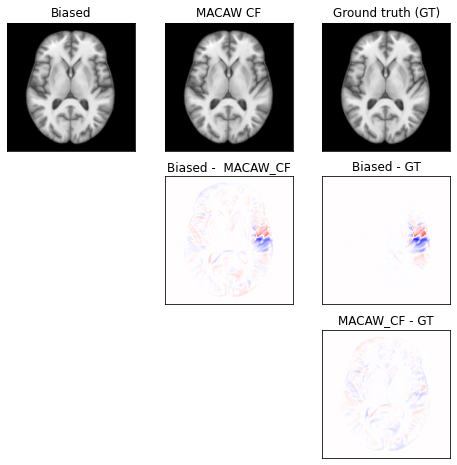

In [34]:
view_images(5)

In [35]:
def TEA(no_bias_img, bias_img, cf_img):
    no_far = (no_bias_img - bias_img).flatten()
    cf_far = (cf_img - bias_img).flatten()

    no_far_mag = np.linalg.norm(no_far)
    cf_far_mag = np.linalg.norm(cf_far)
    projection = no_far.dot(cf_far) / no_far_mag

    bias_removal = projection / no_far_mag
    unwanted_changes = np.sqrt(cf_far_mag**2 - projection**2)

    return bias_removal, unwanted_changes

In [38]:
n = len(df)

macaw_brs = []
macaw_ucs = []

hvae_brs = []
hvae_ucs = []
for i in range(n):
    no, biased, macaw = three_images(i, df)

    br, uc = TEA(no, biased, macaw)
    macaw_brs.append(br)
    macaw_ucs.append(uc)

df["MACAW_effectiveness"] = macaw_brs
df["MACAW_amplification"] = macaw_ucs

In [39]:
df["bias_effect"] = [float(i.split("_")[-2]) for i in df["filename"]]
df["disease_effect"] = [float(i.split("_")[3]) for i in df["filename"]]
df["subject_effect"] = [float(i.split("_")[1]) for i in df["filename"]]
df["isv_dst_abs"] = np.abs(df["isv_dst"])

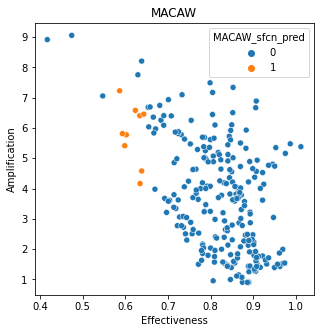

In [52]:
import seaborn as sns

fig, axs = plt.subplots(1, 1, figsize=(5, 5))

sns.scatterplot(
    x="MACAW_effectiveness",
    y="MACAW_amplification",
    hue="MACAW_sfcn_pred",
    data=df,
    ax=axs,
)
axs.set(title="MACAW", xlabel="Effectiveness", ylabel="Amplification")

fig.savefig("results/macaw_sfcn.png")

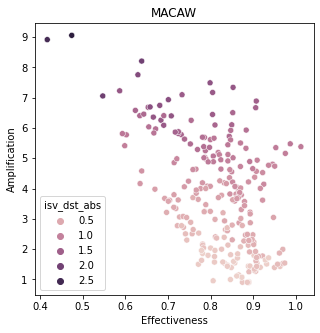

In [53]:
import seaborn as sns

fig, axs = plt.subplots(1, 1, figsize=(5, 5))

sns.scatterplot(
    x="MACAW_effectiveness",
    y="MACAW_amplification",
    hue="isv_dst_abs",
    data=df,
    ax=axs,
)
axs.set(title="MACAW", xlabel="Effectiveness", ylabel="Amplification")
fig.savefig("results/isv.png")